In [6]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from PIL import Image
import os, glob, numpy as np
import pandas as pd
from sklearn import datasets, model_selection
from sklearn.model_selection import train_test_split

In [7]:
img_dir = './dataset'
categories = ['bad', 'good']
np_classes = len(categories)

X = []
y = []

for idx, cat in enumerate(categories):
    
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    
    for i, f in enumerate(files):
        try:
            img = Image.open(f)      #폴더를 열어주고 이미지를 읽음
            img = img.convert("RGB")   #RGB로 바꿈
            resize_img = img.resize((128,128)) #이미지 크기를 모두 학습시키기 쉽게 128x128크기
            
            r, g, b = resize_img.split() # 각 쪼갠 이미지를 255로 나눠서 0~1 사이의 값이 나오도록 정규화한다.
            r_resize_img = np.asarray(np.float32(r) / 255.0)
            b_resize_img = np.asarray(np.float32(g) / 255.0)
            g_resize_img = np.asarray(np.float32(b) / 255.0)
            
            rgb_resize_img = np.asarray([r_resize_img, b_resize_img, g_resize_img]) # 이렇게 가공한 이미지를 추가한다.
            X.append(rgb_resize_img)
            y.append(idx) # 라벨 (ant: 0, bee: 1)
            if i % 700 == 0: #700으로 하면 폴더 명과 파일 길이를 더 
                print(cat, " : ", f)
        except:
            print(cat, str(i)+" 번째에서 에러 ")


X = np.array(X, dtype='float32')
y = np.array(y, dtype='int64')

#1 0  이면 bad
#0 1  이면 good

print("ok", len(y))

bad  파일 길이 :  434
bad  :  ./dataset/bad/4f08fc98-7d4d-43f7-921d-b2ccf8ca726d_270.jpg
good  파일 길이 :  1379
good  :  ./dataset/good/7ebb4762-7de4-4754-8cd2-2d4f743f512c_90.jpg
good  :  ./dataset/good/9eaca121-9239-49f4-9d05-34ef9f10bcaa_225.jpg
ok 1813


In [8]:
r_resize_img = np.asarray(np.float32(r) / 255.0)

In [9]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size)
    relative_train_size = train_size / (val_size + train_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,y,0.6,0.1,0.3)

In [11]:
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()
y_test = torch.from_numpy(y_test).long()

In [12]:
train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers = 4)
val_loader = DataLoader(val, batch_size=32, shuffle=False, num_workers = 4)
test_loader = DataLoader(test, batch_size=32, shuffle=False, num_workers = 4)

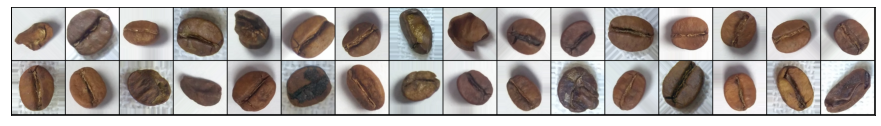

In [14]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,2))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [21]:
## https://bigdatadiary0819.tistory.com/54
## https://wingnim.tistory.com/34(참고)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # 합성곱층
    self.conv1 = nn.Conv2d(3, 10, 5) # 입력 채널 수, 출력 채널 수, 필터 크기
    self.conv2 = nn.Conv2d(10, 20, 5)

    # 전결합층
    self.fc1 = nn.Linear(20 * 29 * 29, 50) # 29=(((((128-5)+1)/2)-5)+1)/2
    self.fc2 = nn.Linear(50, 2)
    

  def forward(self, x):
    # 풀링층
    x = F.max_pool2d(F.relu(self.conv1(x)), 2) # 풀링 영역 크기
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, 20 * 29 * 29)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)

# 인스턴스 생성
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
num_epoch = 50

In [22]:
import torch
import torchvision
import torchsummary
model = Net().to(DEVICE)
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16820, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [23]:
from torchsummary import summary
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 124, 124]             760
            Conv2d-2           [-1, 20, 58, 58]           5,020
            Linear-3                   [-1, 50]         841,050
            Linear-4                    [-1, 2]             102
Total params: 846,932
Trainable params: 846,932
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.69
Params size (MB): 3.23
Estimated Total Size (MB): 5.11
----------------------------------------------------------------


<ipython-input-21-f1d1db9a9ad1>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [24]:
'''
train이 val보다 높으면 과적합
과적합 찾아보기
'''

'\ntrain이 val보다 높으면 과적합\n과적합 찾아보기\n'

In [25]:
# https://hoya012.github.io/blog/DenseNet-Tutorial-2/
criterion = nn.CrossEntropyLoss()

total = 0
correct = 0

for epoch in range(num_epoch):  
    
    total_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        X_train, y_train = data
        X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += y_train.size(0)
        correct += (predicted == y_train).sum().item()
       # a = torch.tensor(torch.sum(predicted == y_train).item() / len(predicted))
        
        
    print('[%d epoch] Accuracy of the network on the train images: %d %% ' % 
       (epoch + 1, 100 * correct / total))
    print('[%d epoch] Loss of the network on the train images: %.3f' % 
          (epoch + 1, total_loss))
        
    print('- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -')    
    # validation part
    correct = 0
    total = 0
    for i, data in enumerate(val_loader, 0):
        X_val, y_val = data
        X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
        outputs = model(X_val)
        
        _, predicted = torch.max(outputs.data, 1)
        total += y_val.size(0)
        correct += (predicted == y_val).sum().item()
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch + 1, 100 * correct / total)
         )
    print('---------------------------------------------------------------------')
    print('---------------------------------------------------------------------')   

print('Finished Training')

<ipython-input-21-f1d1db9a9ad1>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1 epoch] Accuracy of the network on the train images: 24 % 
[1 epoch] Loss of the network on the train images: 23.953
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[1 epoch] Accuracy of the network on the validation images: 27 %
---------------------------------------------------------------------
---------------------------------------------------------------------
[2 epoch] Accuracy of the network on the train images: 25 % 
[2 epoch] Loss of the network on the train images: 23.954
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[2 epoch] Accuracy of the network on the validation images: 27 %
---------------------------------------------------------------------
---------------------------------------------------------------------
[3 epoch] Accuracy of the network on the train images: 25 % 
[3 epoch] Loss of the network on the train images: 23.954
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[3 epoch] Accurac

[22 epoch] Accuracy of the network on the train images: 25 % 
[22 epoch] Loss of the network on the train images: 23.954
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[22 epoch] Accuracy of the network on the validation images: 27 %
---------------------------------------------------------------------
---------------------------------------------------------------------
[23 epoch] Accuracy of the network on the train images: 25 % 
[23 epoch] Loss of the network on the train images: 23.953
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[23 epoch] Accuracy of the network on the validation images: 27 %
---------------------------------------------------------------------
---------------------------------------------------------------------
[24 epoch] Accuracy of the network on the train images: 25 % 
[24 epoch] Loss of the network on the train images: 23.953
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[24 epoch

[43 epoch] Accuracy of the network on the train images: 25 % 
[43 epoch] Loss of the network on the train images: 23.953
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[43 epoch] Accuracy of the network on the validation images: 27 %
---------------------------------------------------------------------
---------------------------------------------------------------------
[44 epoch] Accuracy of the network on the train images: 25 % 
[44 epoch] Loss of the network on the train images: 23.953
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[44 epoch] Accuracy of the network on the validation images: 27 %
---------------------------------------------------------------------
---------------------------------------------------------------------
[45 epoch] Accuracy of the network on the train images: 25 % 
[45 epoch] Loss of the network on the train images: 23.954
- - - - - - - - - - - - - - - - - - - - - -  - - - - - - - - - - -  - -
[45 epoch

In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(num_epoch): 

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            X_test, y_test = data
            X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
            outputs = model(X_test)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == y_test).squeeze()
                
            for i in range(y_test.shape[0]):
                label = y_test[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()
        
    print('[%d epoch] Accuracy of the network on the test images: %d %%' % 
            (epoch + 1, 100 * correct / total))
                      

print('Accuracy of the network on the 544 test images: %d %%' % (
    100 * correct / total))            
            
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        categories[i], 100 * class_correct[i] / class_total[i])) 


[1 epoch] Accuracy of the network on the test images: 21 %


<ipython-input-15-3f1839a47745>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[2 epoch] Accuracy of the network on the test images: 21 %
[3 epoch] Accuracy of the network on the test images: 22 %
[4 epoch] Accuracy of the network on the test images: 21 %
[5 epoch] Accuracy of the network on the test images: 22 %
[6 epoch] Accuracy of the network on the test images: 21 %
[7 epoch] Accuracy of the network on the test images: 21 %
[8 epoch] Accuracy of the network on the test images: 22 %
[9 epoch] Accuracy of the network on the test images: 21 %
[10 epoch] Accuracy of the network on the test images: 21 %
[11 epoch] Accuracy of the network on the test images: 21 %
[12 epoch] Accuracy of the network on the test images: 22 %
[13 epoch] Accuracy of the network on the test images: 21 %
[14 epoch] Accuracy of the network on the test images: 21 %
[15 epoch] Accuracy of the network on the test images: 22 %
[16 epoch] Accuracy of the network on the test images: 21 %
[17 epoch] Accuracy of the network on the test images: 21 %
[18 epoch] Accuracy of the network on the test i